In [ ]:
!pip install transformers pandas torch

#T5 Fine-Tune


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
# Import AdamW from the optimization module
from torch.optim import AdamW
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

optimizer = AdamW(model.parameters(), lr=5e-5)

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/twitter_training_cleaned.csv", header=None, names=["ID", "Category", "Sentiment", "Text"])
df = df[df["Sentiment"].isin(["Positive", "Negative", "Neutral"])]  # Filter clean labels
df["Sentiment"] = df["Sentiment"].str.lower()
df = df.sample(60000)  # use only 60000 samples for fast debugging


# Preprocess
def clean(text):
    text = str(text).lower()
    return " ".join(text.split())

df["Text"] = df["Text"].apply(clean)

# Dataset class
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.tokenizer = tokenizer
        self.inputs = [f"Analyze sentiment: {text}" for text in df["Text"].tolist()]
        self.targets = df["Sentiment"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        input_ids = self.tokenizer.encode(input_text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt").squeeze()
        target_ids = self.tokenizer.encode(target_text, truncation=True, padding="max_length", max_length=10, return_tensors="pt").squeeze()

        return {
            "input_ids": input_ids,
            "labels": target_ids
        }

# Load tokenizer/model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Prepare DataLoader
train_dataset = TweetDataset(df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
model.train()
for epoch in range(7):
    print(f"\n Starting Epoch {epoch + 1}...\n")
    total_loss = 0

    for i, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print every 10 batches
        if i % 10 == 0:
            print(f" Batch {i + 1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    print(f"\n Epoch {epoch + 1} Completed | Total Loss: {total_loss:.4f}")


# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/my_model")
tokenizer.save_pretrained("/content/drive/MyDrive/my_model")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


 Starting Epoch 1...



Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Streaming output truncated to the last 5000 lines.
 Batch 2821/7500 | Loss: 0.0631
 Batch 2831/7500 | Loss: 0.0832
 Batch 2841/7500 | Loss: 0.1323
 Batch 2851/7500 | Loss: 0.1119
 Batch 2861/7500 | Loss: 0.1002
 Batch 2871/7500 | Loss: 0.0834
 Batch 2881/7500 | Loss: 0.0958
 Batch 2891/7500 | Loss: 0.1432
 Batch 2901/7500 | Loss: 0.1298
 Batch 2911/7500 | Loss: 0.1269
 Batch 2921/7500 | Loss: 0.0926
 Batch 2931/7500 | Loss: 0.0799
 Batch 2941/7500 | Loss: 0.0995
 Batch 2951/7500 | Loss: 0.1198
 Batch 2961/7500 | Loss: 0.0914
 Batch 2971/7500 | Loss: 0.1033
 Batch 2981/7500 | Loss: 0.1177
 Batch 2991/7500 | Loss: 0.0902
 Batch 3001/7500 | Loss: 0.0964
 Batch 3011/7500 | Loss: 0.0697
 Batch 3021/7500 | Loss: 0.0915
 Batch 3031/7500 | Loss: 0.0801
 Batch 3041/7500 | Loss: 0.1027
 Batch 3051/7500 | Loss: 0.0842
 Batch 3061/7500 | Loss: 0.0676
 Batch 3071/7500 | Loss: 0.1165
 Batch 3081/7500 | Loss: 0.1071
 Batch 3091/7500 | Loss: 0.1008
 Batch 3101/7500 | Loss: 0.0735
 Batch 3111/7500 | Lo

('/content/drive/MyDrive/my_model/tokenizer_config.json',
 '/content/drive/MyDrive/my_model/special_tokens_map.json',
 '/content/drive/MyDrive/my_model/spiece.model',
 '/content/drive/MyDrive/my_model/added_tokens.json')

#RoBERTa Fine-Tune

In [ ]:
from google.colab import drive

def mount_drive():
    drive.mount('/content/drive')


# 2. dataset_loader.py
import pandas as pd
from sklearn.model_selection import train_test_split

def load_and_prepare_dataset(filepath):
    df = pd.read_csv("/content/drive/MyDrive/twitter_training_cleaned.csv", header=None, names=["twitter_id", "entity", "sentiment", "text"])
    df = df[df["sentiment"].isin(["Positive", "Negative", "Neutral"])]
    df["sentiment"] = df["sentiment"].str.lower()
    df = df.sample(50000)
    df["text"] = df["text"].str.lower().str.strip()
    label2id = {"negative": 0, "neutral": 1, "positive": 2}
    df["label"] = df["sentiment"].map(label2id)
    return train_test_split(df, test_size=0.1, random_state=42), label2id


# 3. tweet_dataset.py
from torch.utils.data import Dataset
import torch

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Check if text is a string and convert if necessary
        if not isinstance(text, str):
            text = str(text)  # Convert to string if not already

        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label)
        }

# 4. train_model.py
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
import torch


def train_roberta(train_loader, model, device, epochs=3):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.train()
    for epoch in range(epochs):
        print(f"\nStarting Epoch {epoch + 1}...\n")
        total_loss = 0
        for i, batch in enumerate(train_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print(f"Batch {i + 1}/{len(train_loader)} | Loss: {loss.item():.4f}")
        print(f"Epoch {epoch + 1} Completed | Total Loss: {total_loss:.4f}")

    return model


# 5. evaluate.py
from sklearn.metrics import accuracy_score
import torch

def evaluate(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


# 6. inference.py
import torch
import torch.nn.functional as F

def predict_sentiment(model, tokenizer, text, label_map, device):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, pred_class = torch.max(probs, dim=1)

    label = label_map[pred_class.item()]
    return label, confidence.item()


# 7. main.py
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torch

mount_drive()
(train_df, val_df), label2id = load_and_prepare_dataset("/content/drive/MyDrive/ColabNotebooks/twitter_training_cleaned.csv")
id2label = {v: k for k, v in label2id.items()}

# Load tokenizer and datasets
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = TweetDataset(train_df, tokenizer)
val_dataset = TweetDataset(val_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load and train model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = train_roberta(train_loader, model, device)

# Save model
model.save_pretrained("/content/drive/MyDrive/roberta_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/roberta_sentiment_model")

# Evaluate
acc = evaluate(model, val_loader, device)
print(f"\nValidation Accuracy: {acc:.4f}")

# Inference loop
while True:
    user_input = input("Enter text (or type 'exit'): ")
    if user_input.lower() == "exit":
        break
    sentiment, conf = predict_sentiment(model, tokenizer, user_input, id2label, device)
    print(f"Predicted Sentiment: {sentiment} (Confidence: {conf:.2f})")


#Hybrid

Evaluating with test CSV: /content/drive/MyDrive/twitter_validation_cleaned.csv
  0%|          | 0/828 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


100%|██████████| 828/828 [01:11<00:00, 11.61it/s]

==== T5 Metrics ====
Accuracy : 0.9577
Precision: 0.9584
Recall   : 0.9578
F1 Score : 0.9580

==== RoBERTa Metrics ====
Accuracy : 0.9384
Precision: 0.9422
Recall   : 0.9391
F1 Score : 0.9389

==== Hybrid Metrics ====
Accuracy : 0.9601
Precision: 0.9613
Recall   : 0.9600
F1 Score : 0.9605


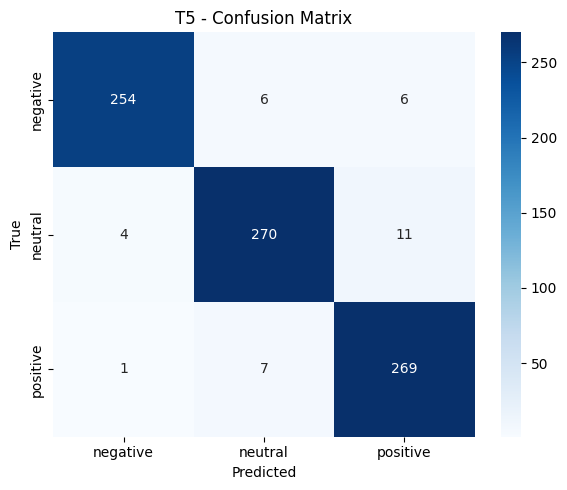

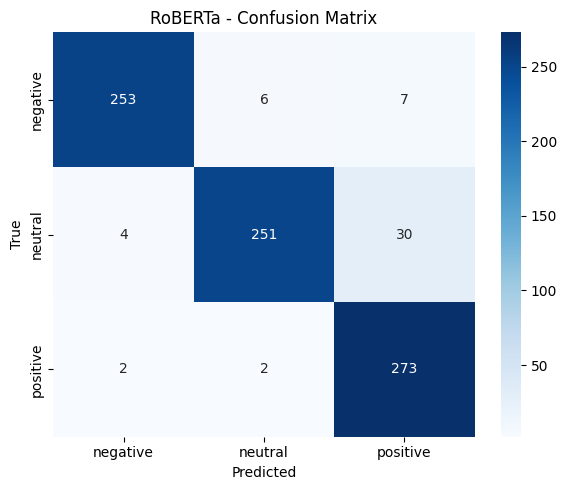

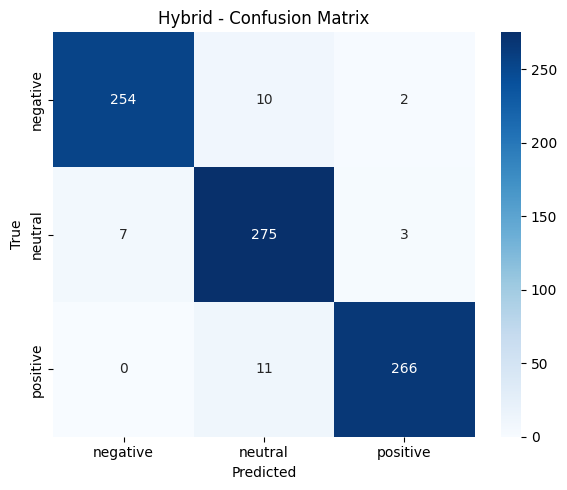

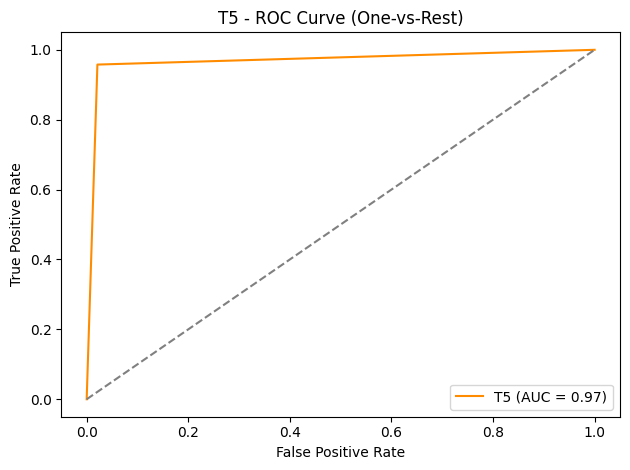

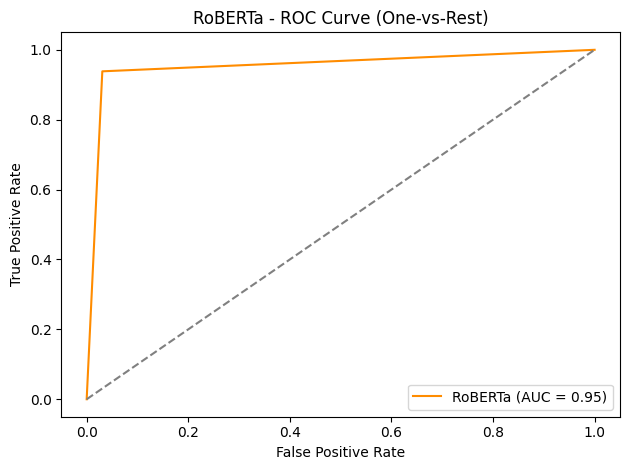

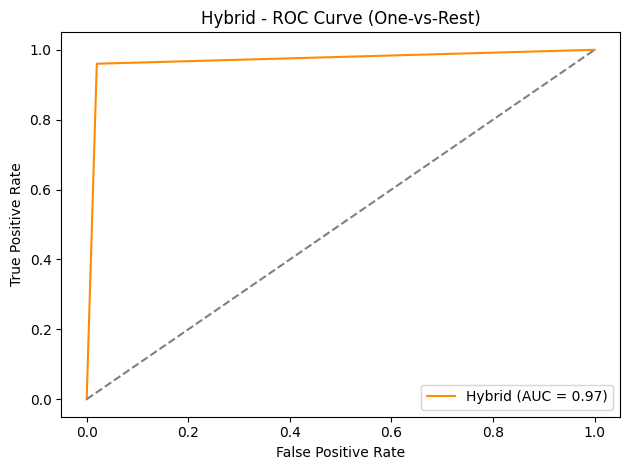

In [1]:
import sys
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    RobertaTokenizer, RobertaForSequenceClassification
)
import tqdm

# CONFIG
TEST_CSV     = "/content/drive/MyDrive/twitter_validation_cleaned.csv"
T5_PATH      = "/content/drive/MyDrive/my_model"
ROBERTA_PATH = "/content/drive/MyDrive/roberta_sentiment_model"
FALLBACK_ROB = "cardiffnlp/twitter-roberta-base-sentiment"
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LABELS = ["negative", "neutral", "positive"]
idx_of = {lbl: i for i, lbl in enumerate(LABELS)}

# LOAD MODELS
t5_tok = T5Tokenizer.from_pretrained(T5_PATH)
t5_mod = T5ForConditionalGeneration.from_pretrained(T5_PATH).to(DEVICE).eval()

try:
    rob_tok = RobertaTokenizer.from_pretrained(ROBERTA_PATH)
    rob_mod = RobertaForSequenceClassification.from_pretrained(ROBERTA_PATH).to(DEVICE).eval()
except OSError:
    rob_tok = RobertaTokenizer.from_pretrained(FALLBACK_ROB)
    rob_mod = RobertaForSequenceClassification.from_pretrained(FALLBACK_ROB).to(DEVICE).eval()

# T5 sentiment prediction with log-likelihood scoring
def t5_probs(text: str):
    prompt_ids = t5_tok.encode(" Analyze Sentiment: " + text.lower(),
                               return_tensors="pt").to(DEVICE)
    log_liks = []
    for lbl in LABELS:
        target_ids = t5_tok.encode(lbl, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            loss = t5_mod(input_ids=prompt_ids, labels=target_ids).loss
        log_liks.append(-loss.item())
    probs = torch.softmax(torch.tensor(log_liks), dim=0)
    best_idx = torch.argmax(probs).item()
    return probs, LABELS[best_idx], probs[best_idx].item()

# RoBERTa sentiment prediction
def roberta_probs(text: str):
    enc = rob_tok(text, return_tensors="pt", truncation=True, padding=True, max_length=64).to(DEVICE)
    with torch.no_grad():
        logits = rob_mod(**enc).logits.squeeze()
    probs = F.softmax(logits, dim=0)
    best_idx = torch.argmax(probs).item()
    return probs, LABELS[best_idx], probs[best_idx].item()

# Hybrid rule-based combining
def combine_labels(t5_lbl, rob_lbl):
    if t5_lbl == rob_lbl:
        return t5_lbl
    pair = {t5_lbl, rob_lbl}
    if "negative" in pair and "neutral" in pair: return "negative"
    if "positive" in pair and "neutral" in pair: return "neutral"
    if "positive" in pair and "negative" in pair: return "neutral"
    return "neutral"

def pretty_probs(probs):
    return ", ".join(f"{lbl}:{probs[idx_of[lbl]]:.2f}" for lbl in LABELS)


def print_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n==== {model_name} Metrics ====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred, model_name):
    y_true_bin = label_binarize(y_true, classes=LABELS)
    y_pred_bin = label_binarize(y_pred, classes=LABELS)
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})", color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def evaluate_on_test(csv_path=TEST_CSV):
    df = pd.read_csv(csv_path, header=None, names=["ID","Category","Sentiment","Text"])
    df = df[df["Sentiment"].isin(["Positive", "Negative", "Neutral"])]
    df["Sentiment"] = df["Sentiment"].str.lower()
    df["Text"] = df["Text"].astype(str).str.lower().str.strip()

    y_true, y_t5, y_roberta, y_hybrid = [], [], [], []

    print(f"Evaluating with test CSV: {csv_path}")
    for txt, true_label in tqdm.tqdm(zip(df["Text"], df["Sentiment"]), total=len(df), file=sys.stdout):
        t5_p, t5_label, _ = t5_probs(txt)
        rb_p, rb_label, _ = roberta_probs(txt)
        final_label = combine_labels(t5_label, rb_label)

        y_true.append(true_label)
        y_t5.append(t5_label)
        y_roberta.append(rb_label)
        y_hybrid.append(final_label)

    # Metrics
    print_metrics(y_true, y_t5, "T5")
    print_metrics(y_true, y_roberta, "RoBERTa")
    print_metrics(y_true, y_hybrid, "Hybrid")

    # Confusion Matrix
    plot_conf_matrix(y_true, y_t5, "T5")
    plot_conf_matrix(y_true, y_roberta, "RoBERTa")
    plot_conf_matrix(y_true, y_hybrid, "Hybrid")

    # ROC Curve
    plot_roc_curve(y_true, y_t5, "T5")
    plot_roc_curve(y_true, y_roberta, "RoBERTa")
    plot_roc_curve(y_true, y_hybrid, "Hybrid")


if __name__ == "__main__":
    evaluate_on_test(TEST_CSV)



In [2]:
print("\nHybrid Sentiment analysis (type 'exit' to quit)")
while True:
  user_text = input("\nEnter sentence: ").strip()
  if user_text.lower() == "exit":
    break
  if not user_text:
    continue
  t5_probs_,  t5_label,  t5_conf  = t5_probs(user_text)
  rb_probs_,  rb_label,  rb_conf  = roberta_probs(user_text)
  final_lab = combine_labels(t5_label, rb_label)

  print("\nT5 probabilities     :", pretty_probs(t5_probs_))
  print(f"T5 prediction        : {t5_label}  (conf {t5_conf:.2f})")
  print("\nRoBERTa probabilities:", pretty_probs(rb_probs_))
  print(f"RoBERTa prediction   : {rb_label}  (conf {rb_conf:.2f})")
  print(f"\n⇒ FINAL SENTIMENT    : **{final_lab.upper()}**")



Hybrid Sentiment analysis (type 'exit' to quit)

Enter sentence: I hate to say this, but BMW is the best car production company ever

T5 probabilities     : negative:0.02, neutral:0.04, positive:0.93
T5 prediction        : positive  (conf 0.93)

RoBERTa probabilities: negative:0.01, neutral:0.00, positive:0.99
RoBERTa prediction   : positive  (conf 0.99)

⇒ FINAL SENTIMENT    : **POSITIVE**

Enter sentence: i hate to say this, but you are not eligible for this job, better luck next time

T5 probabilities     : negative:0.76, neutral:0.21, positive:0.03
T5 prediction        : negative  (conf 0.76)

RoBERTa probabilities: negative:0.95, neutral:0.03, positive:0.02
RoBERTa prediction   : negative  (conf 0.95)

⇒ FINAL SENTIMENT    : **NEGATIVE**

Enter sentence: wonderful thing to ruin my day again

T5 probabilities     : negative:0.87, neutral:0.02, positive:0.11
T5 prediction        : negative  (conf 0.87)

RoBERTa probabilities: negative:0.85, neutral:0.01, positive:0.14
RoBERTa predi